![Astrofisica Computacional](../../logo.PNG)

---
## Adaptative RK4 method to describe the motion of a particle in a gravitational field


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Summary

This notebook presents the application of the adaptative RK4 method to the problem of the motion of a particle in a gravitational field.

---

In [1]:
import numpy as np

# Newtonian Gravitational Constant
G = 4.*np.pi**2
M = 1.

def f(t0, q0):
    '''
    ------------------------------------------
    f(t0, q0) 
    ------------------------------------------
    ODEs system for the motion of a comet 
    around the Sun using cartesian coordinates
    in the orbital plane.
    ------------------------------------------
    Arguments:
    t0: initial time
    q0: numpy array with the initial condition
        data:
        q0[0] = x
        q0[1] = y
        q0[2] = dx/dt
        q0[3] = dy/dt
    ------------------------------------------
    Dependeces: NumPy
    ------------------------------------------
    '''
    f = np.zeros(4)
    f[0] = q0[2]
    f[1] = q0[3]
    f[2] = - G*M*q0[0]/(q0[0]**2 + q0[1]**2)**(3/2)
    f[3] = - G*M*q0[1]/(q0[0]**2 + q0[1]**2)**(3/2)
    return f

def conserv_quant(q):
    '''
    ------------------------------------------
    conserv_quant(q)
    ------------------------------------------
    Evaluates the total energy and the total 
    angular momentum for the system 
    ------------------------------------------
    Arguments:
    q: NumPy array with the state of the 
       system in the format
       q = [t, x, y, vx, vy]
    ------------------------------------------
    Returns:
    E : Total Energy
    L : Total Angular Momentum
    ------------------------------------------
    Dependeces: NumPy
    ------------------------------------------
    '''
    CQ = np.zeros([len(q),3])
    CQ[:,0] = q[:,0] 
    v2 = q[:,3]**2 + q[:,4]**2
    r = np.sqrt(q[:,1]**2 + q[:,2]**2)
    E = v2/2 - G*M/r
    L = q[:,1]*q[:,4] - q[:,2]*q[:,3]
    CQ[:,1] = E
    CQ[:,2] = L
    return CQ


Summarizing these results, to obtain a bounded orbit for the comet's motion, the initial condition will be imposed

\begin{equation}
    \begin{cases}
    x_0 = & 1\text{au}\\
    y_0 = & 0 \\
    v^x = & 0 \\
    v^y = & 3\frac{\text{au}}{\text{yr}}.
    \end{cases}
\end{equation}

The temporal grid that will be used to apply the integration method will be defined from $t_0 = 0$ to $t_f = 20$ years.

In [3]:
# Computation time
import time

# Adaptative Runge-Kutta 4 Algorithm
def ARK4(ODE, t0, q0, tf, n, dt = 1e-2, epsilon = 1e-8):
    '''
    ------------------------------------------
    RK4(ODE, t0, q0, tf, n, dt, epsilon)
    Adaptative 4th Order Runge-Kutta method 
    for solving a system of ODEs.
    ------------------------------------------
    Arguments:
    ODE: function defining the system of ODEs
    t0: independent parameter initial value
    q0: numpy array with the initial values of
        the functions in the ODEs system
    tf: independent parameter final value
    n: Max number of steps for the integration
    dt: Initial value of the stepsize
    epsilon: Tolerance of the adaptative 
             method
    ------------------------------------------
    Dependences: NumPy
    ------------------------------------------
    '''
    # Initial Condition
    q = np.zeros([n,len(q0)+1])
    q[0,0] = t0
    q[0,1:] = q0
    
    # k-functions for the RK4 algorithm
    def ks(qn,dt):
        k1 = dt*ODE(qn[0], qn[1:])
        k2 = dt*ODE(qn[0] + dt/2, qn[1:] + k1[:]/2)
        k3 = dt*ODE(qn[0] + dt/2, qn[1:] + k2[:]/2)
        k4 = dt*ODE(qn[0] + dt, qn[1:] + k3[:])
        return (k1 + 2*k2 + 2*k3 + k4)/6
    
    # time and index counters
    time = t0
    i = 1
    while i<n-1 and time<tf:
        # 2 steps with dt
        q[i,1:] = q[i-1,1:] + ks(q[i-1,:],dt)[:]
        q[i+1,1:] = q[i,1:] + ks(q[i,:],dt)[:]
        q1 = q[i+1,1:]
        # 1 step with 2dt
        q2 = q[i-1,1:] + ks(q[i-1,:],2*dt)[:]
        
        Theta = np.sqrt((q1[0]-q2[0])**2 + (q1[1]-q2[1])**2)/(30*dt*epsilon)
        if Theta<1:
            q[i,0] = q[i-1,0] + dt
            q[i+1,0] = q[i,0] + dt
            time += 2*dt
            i += 2
            dt = dt*(Theta**(-0.25))
        else:
            dt = dt*(Theta**(-0.25))
            continue
    Q = q[:i] # Keep only the obtained data (discard extra zeros in the array)
    print(f'At time t_f = {time:.2f}, there were {i:g} calculated steps.\n')
    return Q


# Creation of the time grid (in years)
t0 = 0.
tf = 20.

# Number of steps in the grid
n = 100000

# Constant stepsize defined by the number of steps in the grid
#dt = (tf - t0)/n

# Initial Conditions
x = 1. # [au]
y = 0. # [au]
vx = 0. # [au/yr]
vy = 3. # [au/yr]
Q0 = np.array([x, y, vx, vy])

# Solving the System
start = time.time()
Q = ARK4(f, t0, Q0, tf, n)
conservedQuantities = conserv_quant(Q)
end = time.time()
print('The computation time was:', end - start)

At time t_f = 20.00, there were 24953 calculated steps.

The computation time was: 0.8663570880889893


Visualization of the x-coordinate as function of time: 

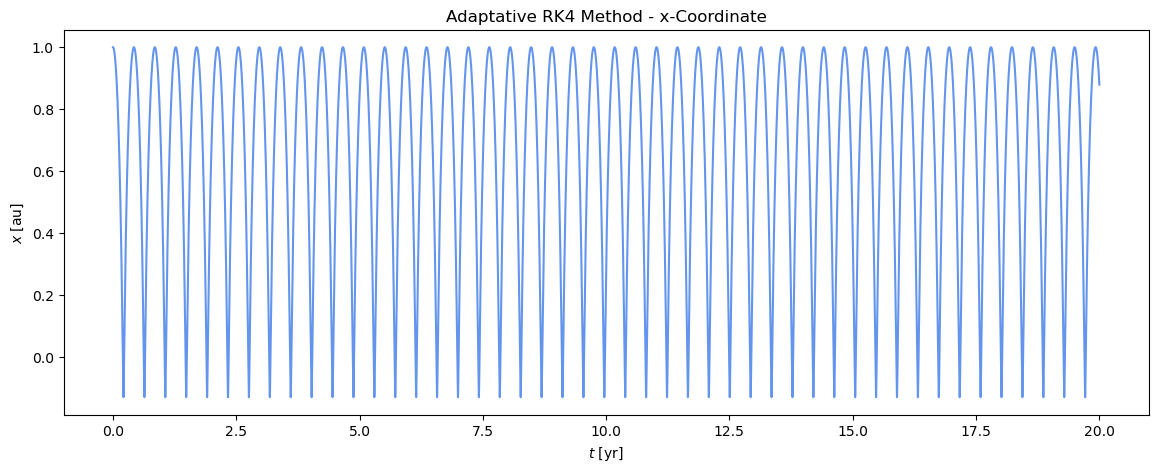

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(Q[:,0], Q[:,1], color='cornflowerblue')
ax.set_title('Adaptative RK4 Method - x-Coordinate')
ax.set_xlabel(r'$t$ [yr]')
ax.set_ylabel(r'$x$ [au]')
#ax.legend()

plt.show()

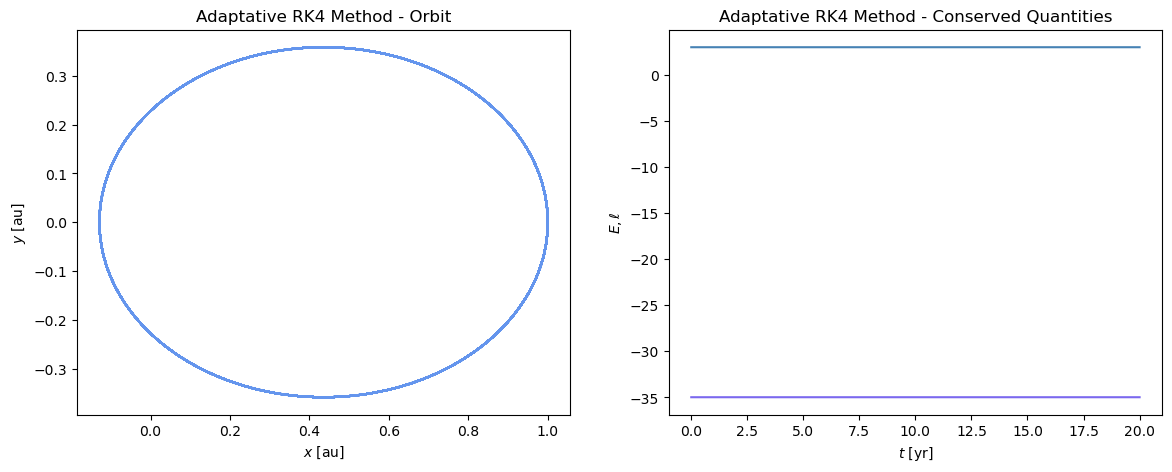

In [5]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(Q[:,1], Q[:,2], color='cornflowerblue')#, label=f'$dt=$ {dt:.2e} yr')
ax[0].set_title('Adaptative RK4 Method - Orbit')
ax[0].set_xlabel(r'$x$ [au]')
ax[0].set_ylabel(r'$y$ [au]')
#ax[0].legend()

ax[1].plot(conservedQuantities[:,0], conservedQuantities[:,1], color='mediumslateblue', label=f'Energy')
ax[1].plot(conservedQuantities[:,0], conservedQuantities[:,2], color='steelblue', label=f'Angular Momentum')
ax[1].set_title('Adaptative RK4 Method - Conserved Quantities')
ax[1].set_xlabel(r'$t$ [yr]')
ax[1].set_ylabel(r'$E, \ell$')
#ax[1].legend()

plt.show()

In [6]:
print('The energy change is :', np.abs(conservedQuantities[-1,1] - conservedQuantities[0,1]))
print('\nThe angular momentum change is :', np.abs(conservedQuantities[-1,2] - conservedQuantities[0,2]))

The energy change is : 1.4026788051069161e-06

The angular momentum change is : 1.799910576139041e-08


---

Visualization of the x-coordinate as funtion of time showing the adaptative steps,

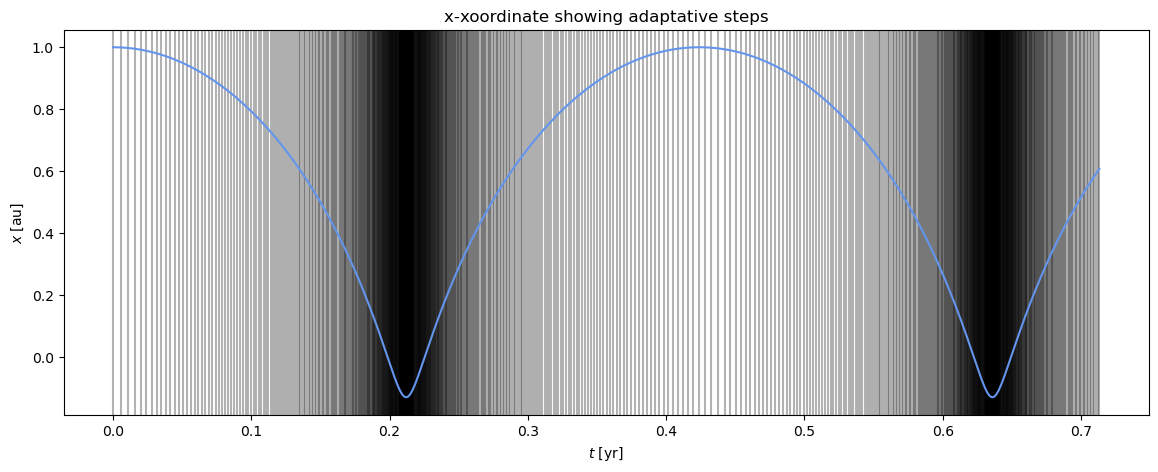

In [7]:
fig, ax = plt.subplots(figsize=(14,5))
for i in range(1000):
    ax.axvline(Q[i,0], color='black', alpha=0.3)
ax.plot(Q[:1000,0], Q[:1000,1], color='cornflowerblue')
ax.set_title('x-xoordinate showing adaptative steps')
ax.set_xlabel(r'$t$ [yr]')
ax.set_ylabel(r'$x$ [au]')
#ax.legend()

plt.show()

In [64]:
# Save data of the orbit
#np.savetxt('particle_orbit(A).txt', Q, header='t x y vx vy')